

# Content

 
#### 2. EDA
#### 3. Feature Engineering
#### 4. Modeling & Evaluation
#### 5. Ensemble Methods


During working on this competition we did a lot of experiments with a lot of research, all the resources we have benefited from have been listed at the end of this notebook.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# Load the data
house_train = pd.read_csv('all/train.csv')
house_test = pd.read_csv('all/test.csv')

# remove spaces from column names
house_train.columns = [col.replace(' ','') for col in house_train.columns]
house_test.columns = [col.replace(' ','') for col in house_test.columns]

In [4]:
num_train = house_train.shape[0]
house_train.shape

(2051, 82)

In [5]:
house_test.shape

(879, 80)

### Removing Outliers

Regression models are very sensitive to outliers 
so we decide to remove some outliers form the highest correlated columns with our target (Saleprice )
as we know removing all them may affect badly our models, so instead of removing them all, we will manage to make some of our models robust on them. 

**Note:** After experiments, we noticed that removing outliers is the most effective step that improved models performance.

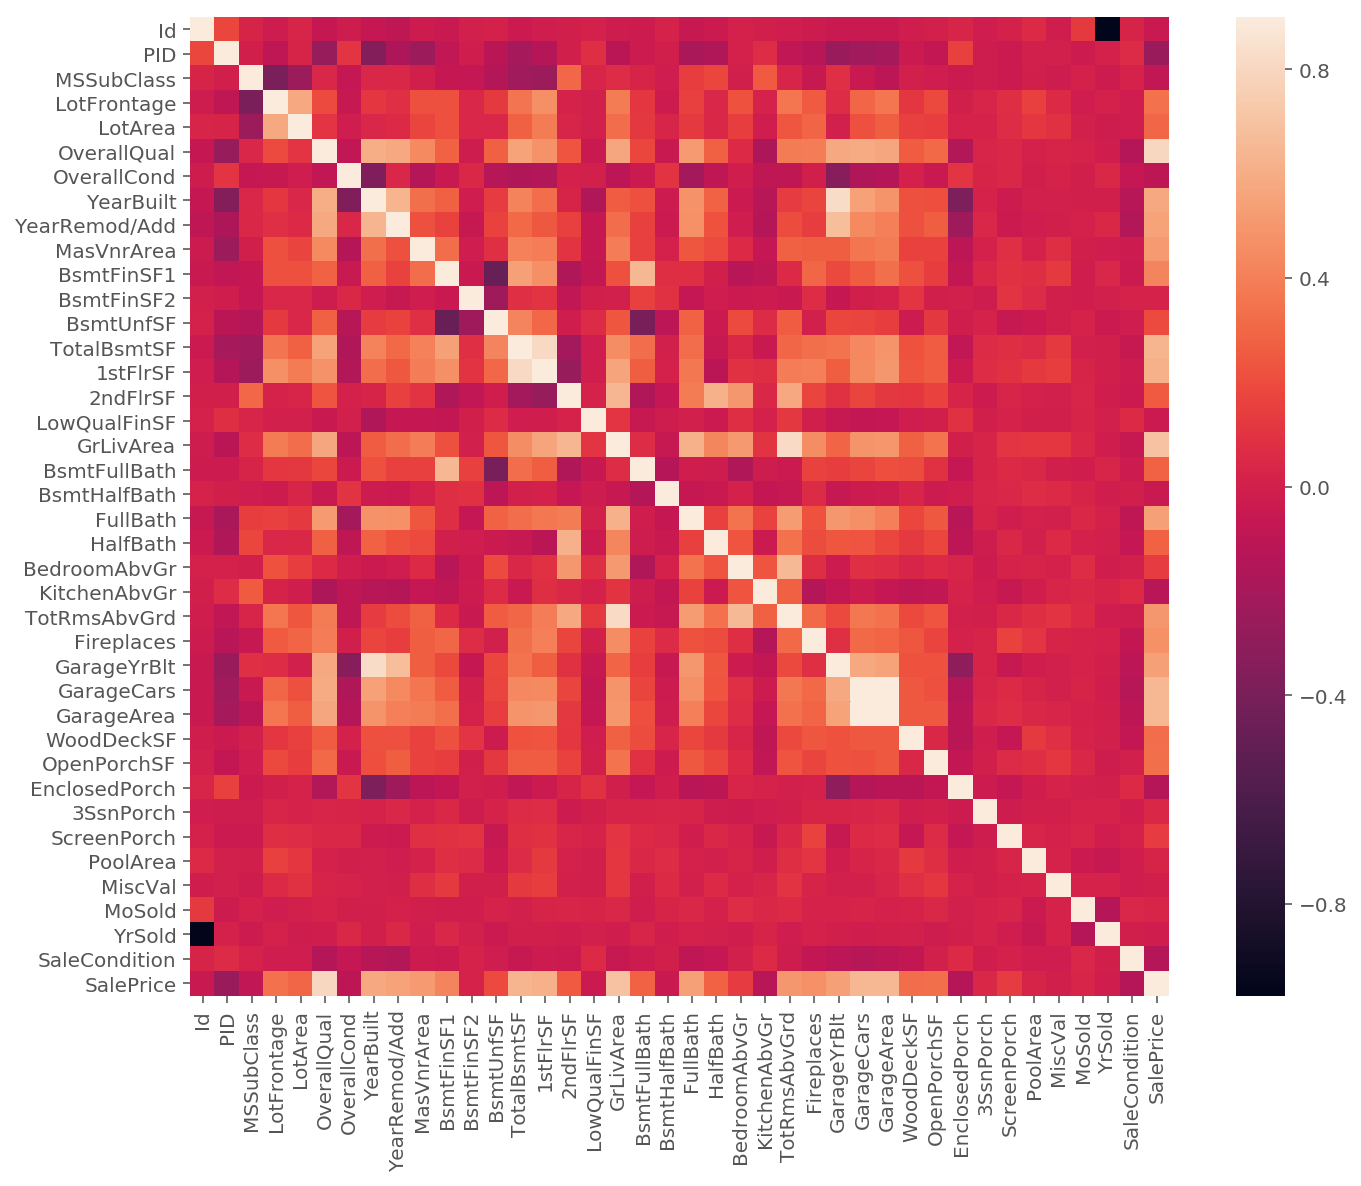

In [6]:
corrmat = house_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True);

In [7]:
# check the top 6 correlated varibles with our target SalePrice inoreder to remove outlers fornm them
corrmat.SalePrice.abs().nlargest(7)[1:]

OverallQual    0.800207
GrLivArea      0.697038
GarageArea     0.650270
GarageCars     0.648220
TotalBsmtSF    0.628925
1stFlrSF       0.618486
Name: SalePrice, dtype: float64

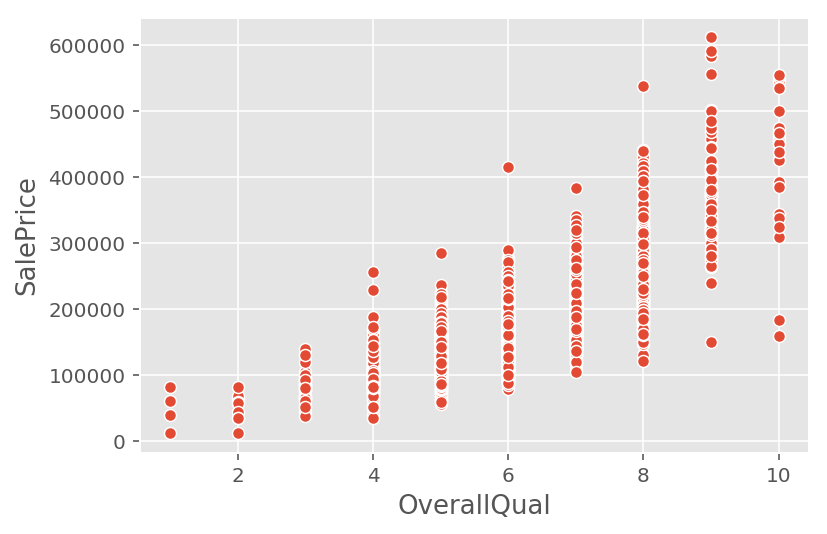

In [8]:
sns.scatterplot(x = house_train['OverallQual'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13);

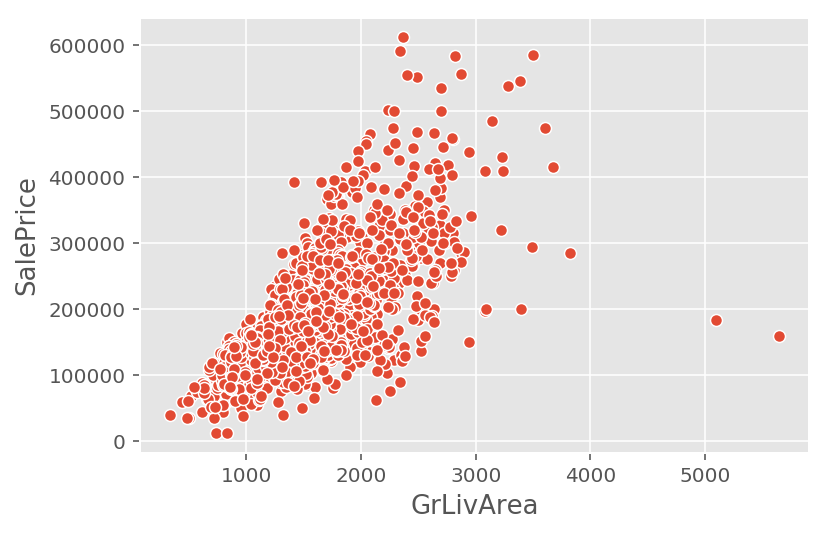

In [9]:
sns.scatterplot(x = house_train['GrLivArea'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13);

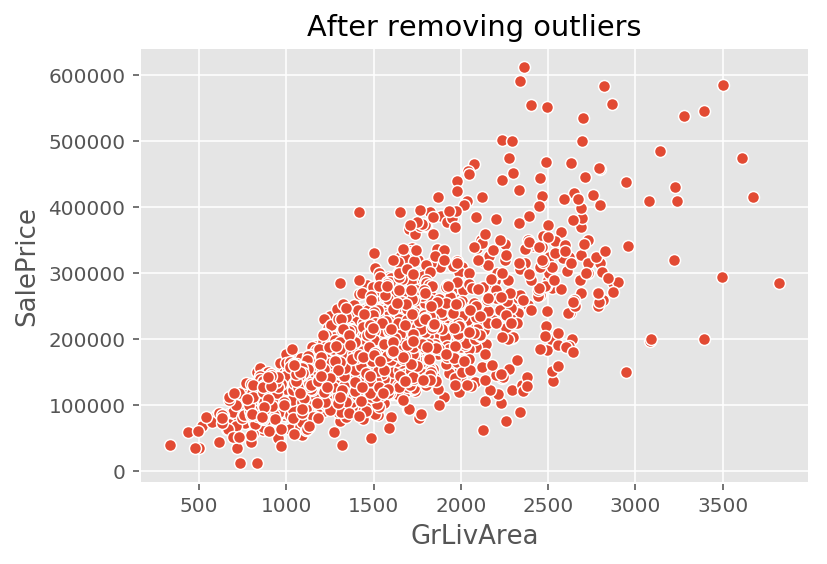

In [10]:
house_train = house_train[ ~((house_train['GrLivArea']>4000)&(house_train['SalePrice']<300000))]
sns.scatterplot(x = house_train['GrLivArea'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('After removing outliers');

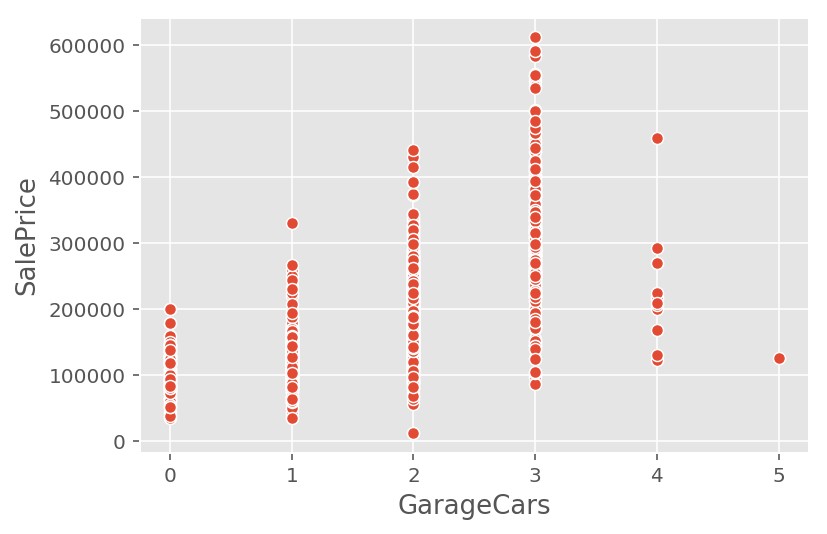

In [11]:
sns.scatterplot(x = house_train['GarageCars'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageCars', fontsize=13);

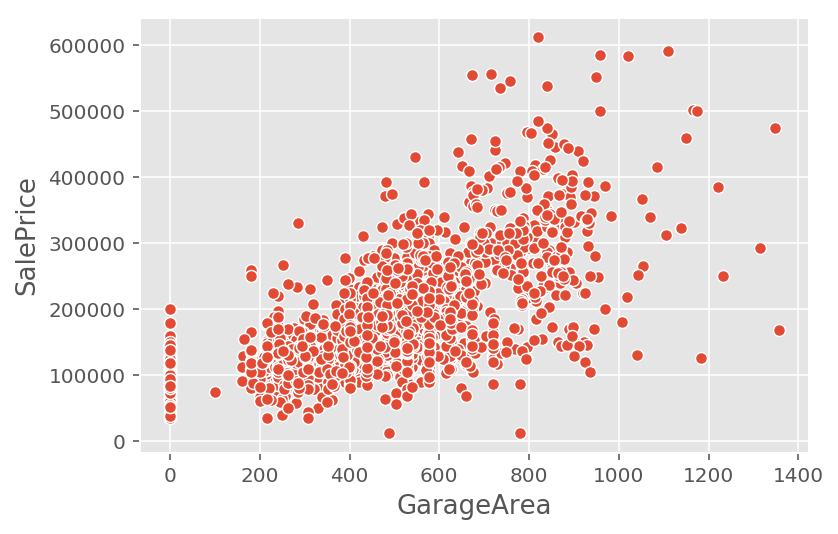

In [12]:
sns.scatterplot(x = house_train['GarageArea'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13);

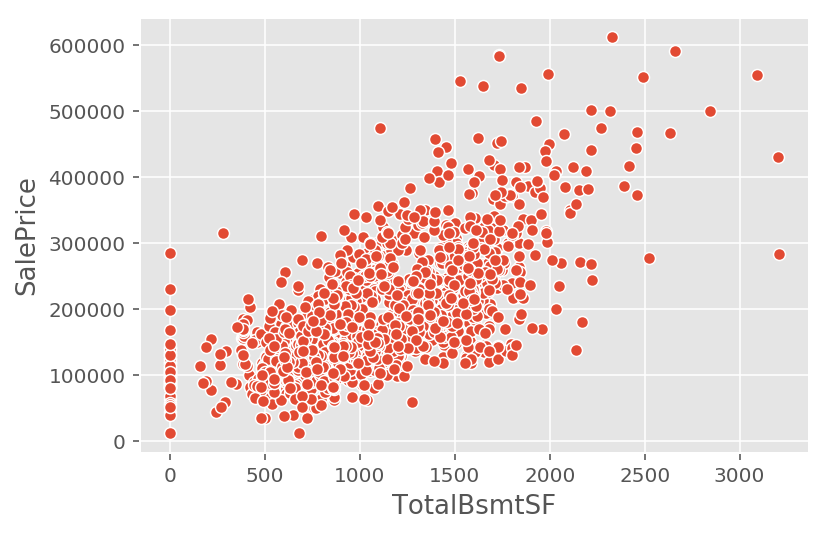

In [13]:
sns.scatterplot(x = house_train['TotalBsmtSF'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13);

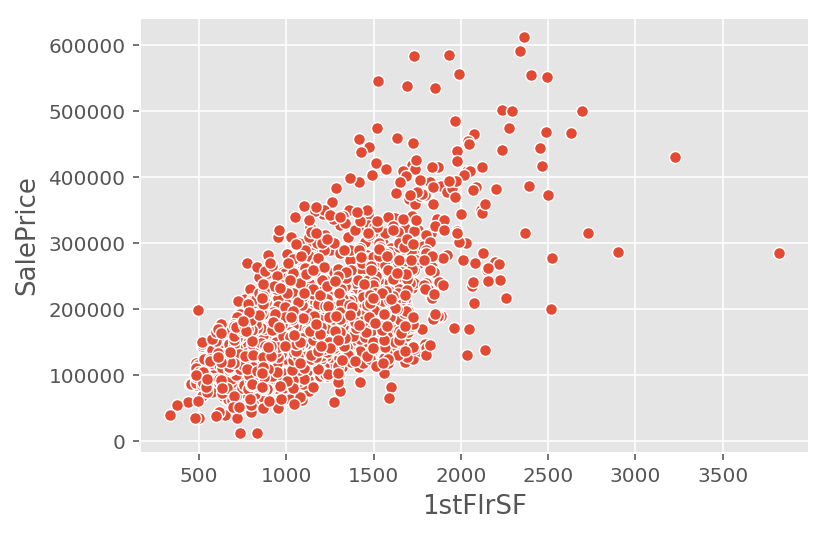

In [14]:
sns.scatterplot(x = house_train['1stFlrSF'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('1stFlrSF', fontsize=13);

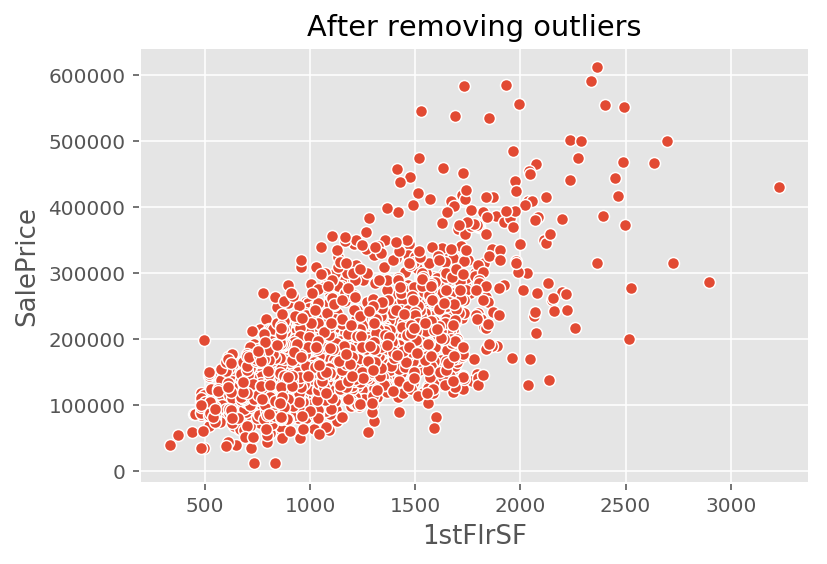

In [15]:
house_train = house_train[ ~((house_train['1stFlrSF']>3500)&(house_train['SalePrice']<300000))]
sns.scatterplot(x = house_train['1stFlrSF'], y = house_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('1stFlrSF', fontsize=13)
plt.title('After removing outliers');

In [16]:
num_train = house_train.shape[0]
num_train

2048

In [17]:
# merging train data and test data for EDA
# we'll also remove 'Id' since this is not an informative feature
# removing the target columns: 'Sale Condition' and 'SalePrice'
house = pd.concat([house_train.drop(['Id', 'SalePrice','SaleCondition'],axis = 1), house_test.drop(['Id'],axis = 1)],ignore_index=True)

In [18]:
house.shape

(2927, 79)

## Features engineering

### Missing data 

In [19]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood [2]
house["LotFrontage"] = house.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [20]:
# fill in with mode [2]
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    #As we cannot see test set we will take the mode for the training set
    #train_mod = house_train[col].mode()[0]
    house[col].fillna(house[col].mode()[0], inplace=True)

### Converting categorical columns & Handling remaining missing data 

We have two type of **non-numeric features** Ordinal and Nominal we will deal with each of them differently:



* OrdinalEncoder will be used to convert all **Ordinal** Data ( categorical variable that that can be ordered)

* OneHotEncoder will be used to convert **Nominal** Data ( without any particular implied order)


##### Handling missing data: 

we will fill the remaining missing data by "Na" (not available)

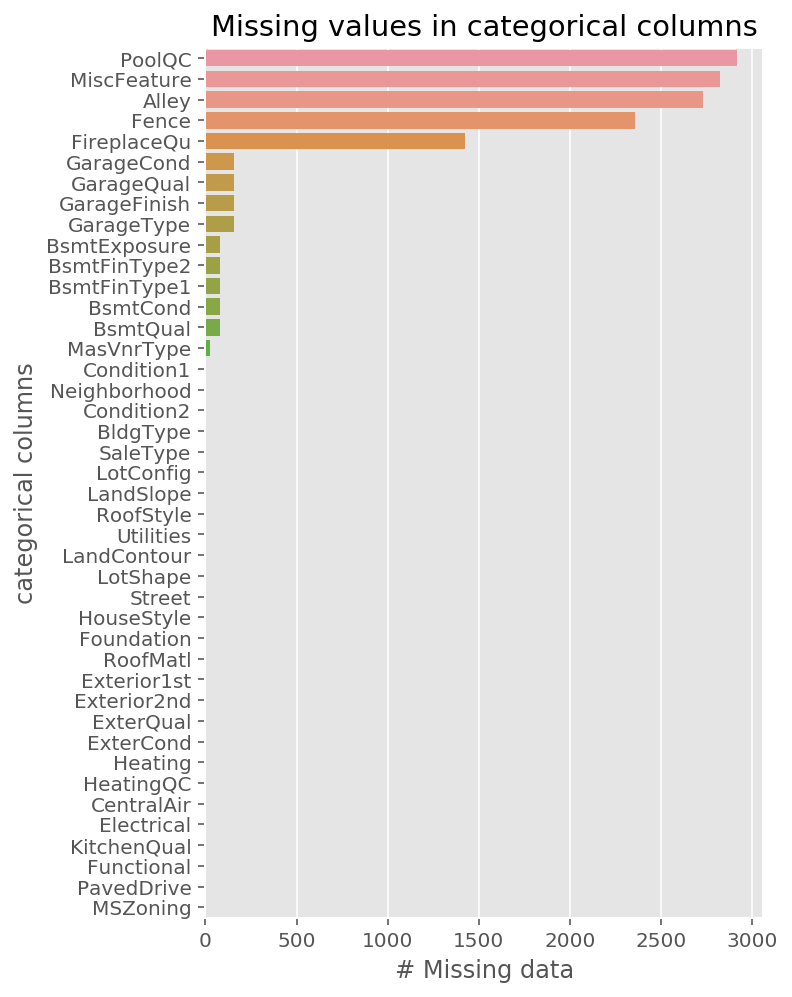

In [21]:
# missing values in categorical columns
miss_categ = (house.select_dtypes(exclude=[np.number]).isnull().sum()).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(y= miss_categ.index, x= miss_categ.values)
ax.set( xlabel="# Missing data" , ylabel="categorical columns", title="Missing values in categorical columns");

In [22]:
# Some of the non-numeric predictors are stored as numbers; we will convert them into strings [2]

NumStr = ["MSSubClass",'OverallCond',"MoSold","YrSold","YearBuilt","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    house[col]=house[col].astype(str)

In [23]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [24]:
# Converting Ordinal columns

ordinal_cols = ['KitchenQual', 'BsmtFinType2', 'GarageYrBlt', 'BsmtCond', 'GarageQual', 'YrSold',
                'BsmtExposure', 'LowQualFinSF', 'GarageCond', 'PoolQC', 'Fence', 'MSSubClass', 'HeatingQC', 
                'ExterCond', 'BsmtFinType1', 'BsmtQual', 'Alley', 'ExterQual', 'MoSold', 'FireplaceQu', 'YearBuilt',
                'LandContour', 'OverallCond', 'GarageFinish', 'LotShape', 'LandSlope','MSZoning','Neighborhood',
               'Functional','Condition1']

# fill the missing values with Na 
house[ordinal_cols] = house[ordinal_cols].fillna('Na')

ordinal_conv = OrdinalEncoder().fit_transform(house[ordinal_cols])

category_df1 = pd.DataFrame(ordinal_conv , columns=ordinal_cols )

In [25]:
# Converting Nominal columns
# we will not convert the Nominal columns because it will greatly increase the dimensionality of the features.
nominal_cols = ['Exterior2nd', 'Condition1', 'Neighborhood', 'RoofMatl', 'CentralAir', 'MSZoning', 'RoofStyle', 
                'MiscFeature', 'SaleType', 'GarageType', 'BldgType', 'HouseStyle', 'Street', 'MasVnrType', 'Exterior1st',
                'Condition2', 'Foundation', 'LotConfig', 'Utilities', 'Electrical', 'Functional', 'Heating', 'PavedDrive']

# fill the missing values with Na

house[nominal_cols] = house[nominal_cols].fillna('Na')
nominal_conv = OneHotEncoder().fit_transform(house[nominal_cols])

category_df2 = pd.DataFrame(nominal_conv.todense())

### Handling missing values in numerical columns

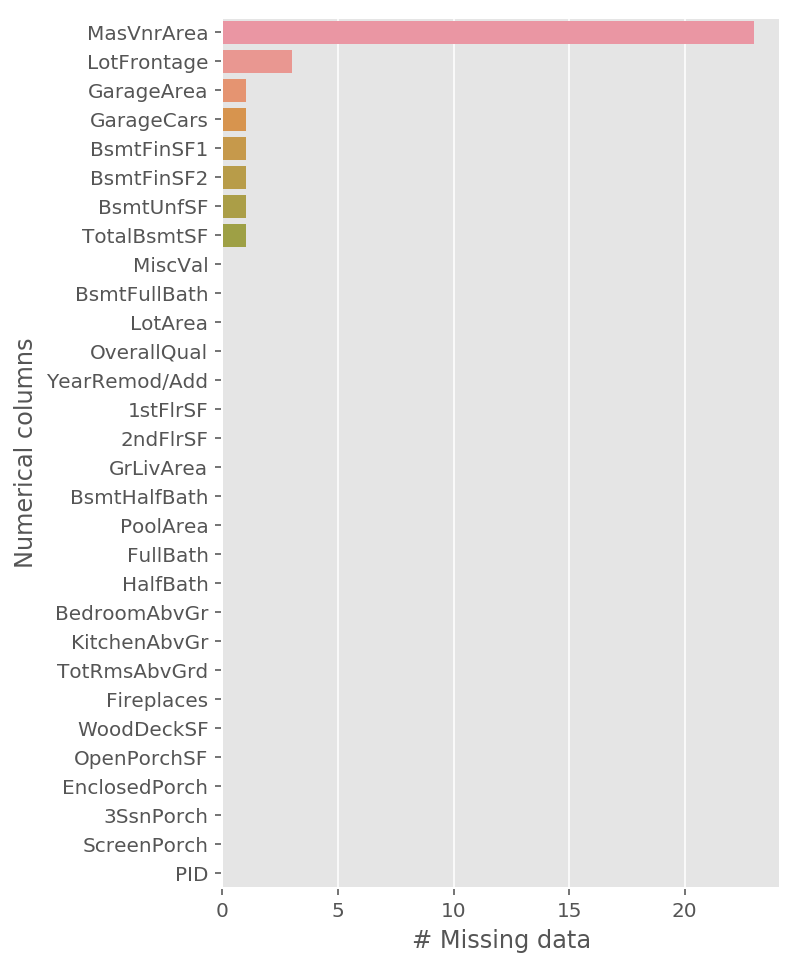

In [26]:
import copy
# missing values in numerical columns

numeric_df = copy.deepcopy( house.select_dtypes(include=[np.number]))
                                   
miss_numeric = numeric_df.isnull().sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(5,8))
sns.barplot(y= miss_numeric.index, x= miss_numeric.values)
ax.set( xlabel="# Missing data" , ylabel="Numerical columns");

In [27]:
numeric_df.fillna(0, inplace=True)

### Fixing the Skewness

After trying alot of experiments the models would did not achieve good results even with all the hyperparameter tuning, and after doing some research we realized that if the dataset skewed, then models wouldn’t perform well.

So, we need to fix the skewness to make a better prediction by the model.

we will apply log transform to our target and to the skewed features.



In [28]:
from scipy.stats import skew

all_numeric = pd.concat([numeric_df, category_df1] , axis=1)

skewness = all_numeric.apply(lambda x: skew(x)).sort_values(ascending=False)
#sns.barplot(x=skewness.index , y = skewness.values)
skewness_features = skewness[abs(skewness) >= 1 ].index
all_numeric[skewness_features] = np.log1p(all_numeric[skewness_features])

### Train and Test sets

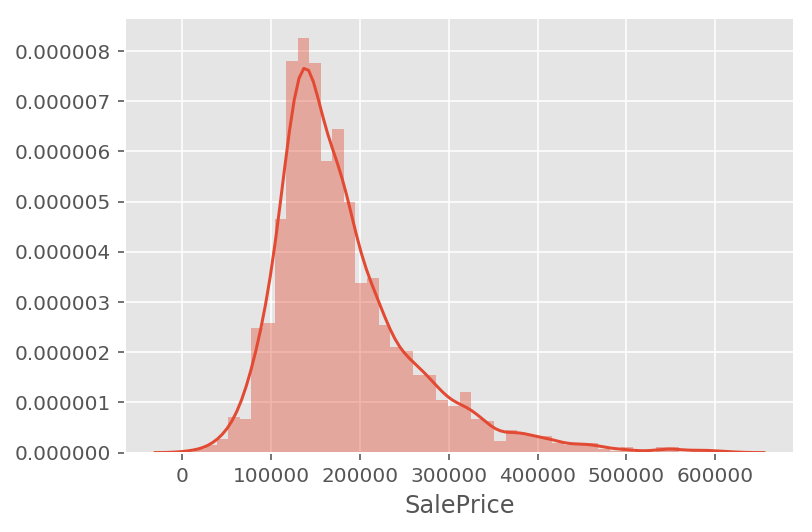

In [29]:
# target Skewness
sns.distplot(house_train.SalePrice);

In [30]:
X = pd.concat([all_numeric, category_df2] , axis=1)
# Fix target Skewness by log
y = np.log(house_train.SalePrice)

In [31]:
X.shape , y.shape

((2927, 239), (2048,))

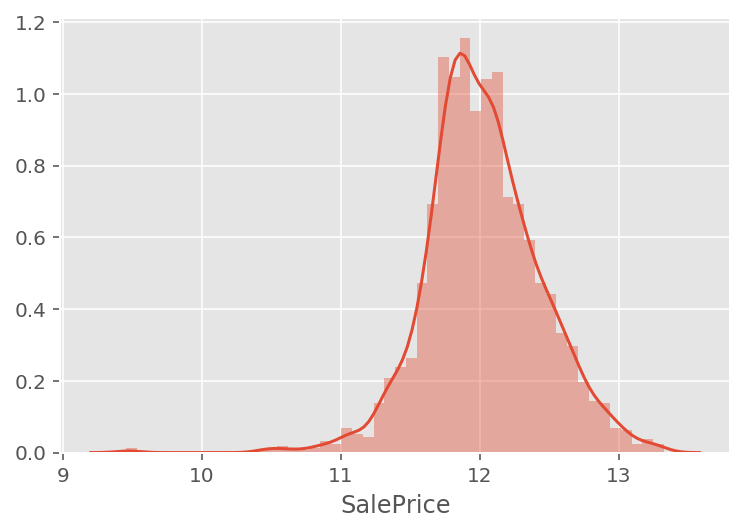

In [33]:
sns.distplot(y);

In [34]:
X_train = X[:num_train]
X_test = X[num_train:]

In [35]:
y.shape , X_train.shape

((2048,), (2048, 239))

### Feature selection

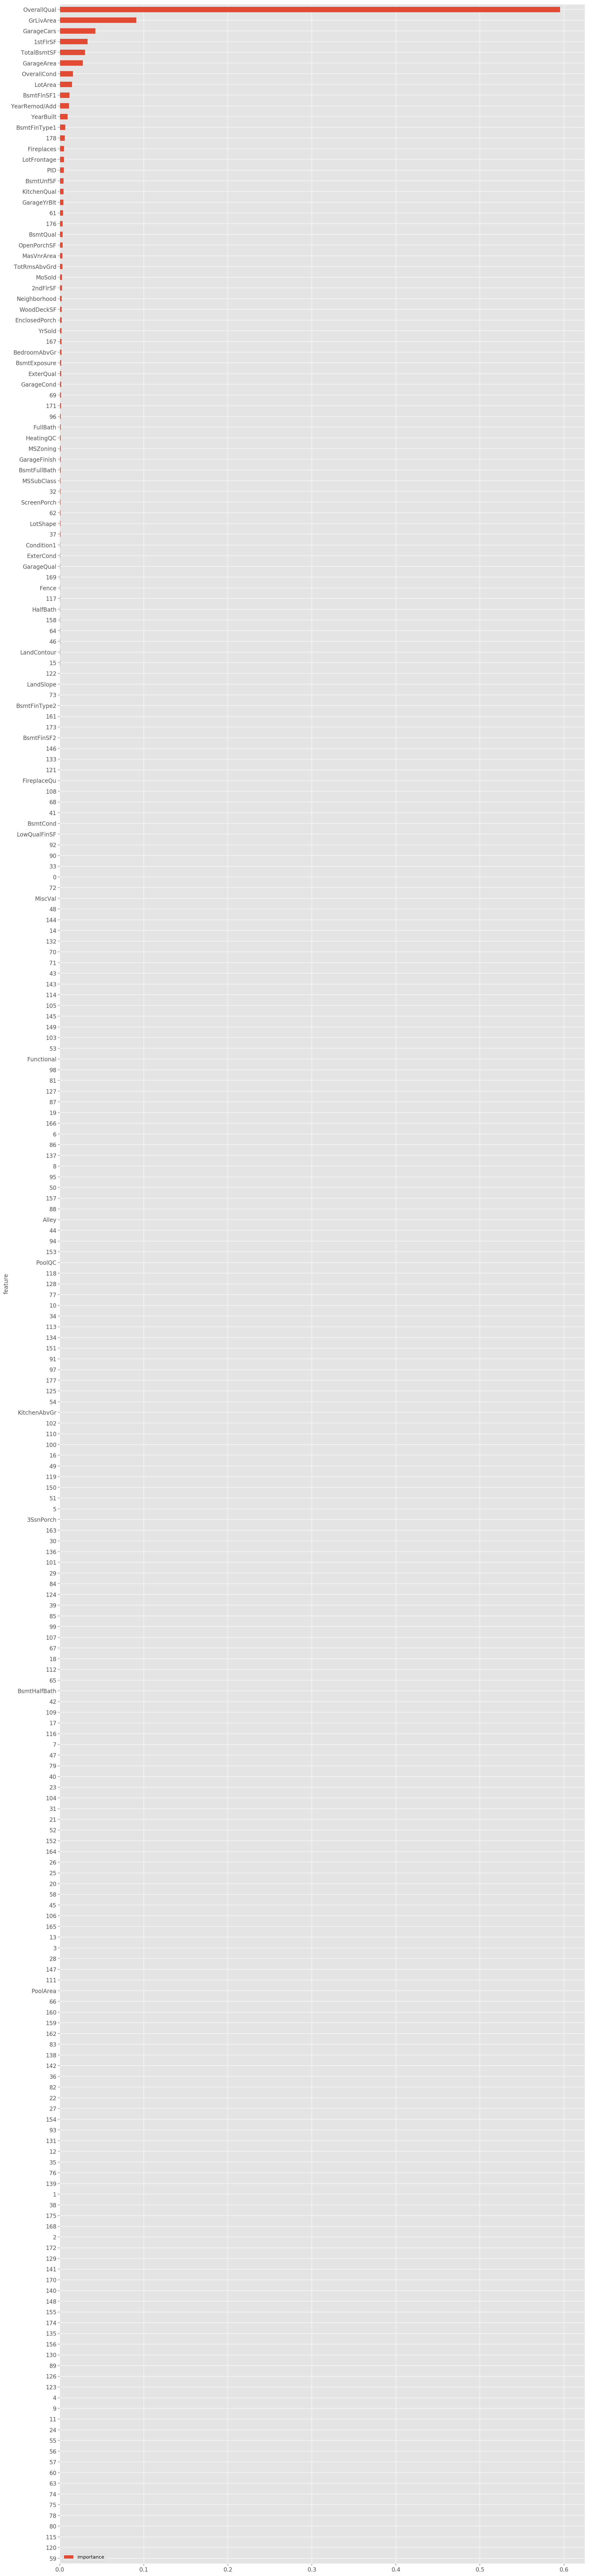

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', RobustScaler()), ('rf', RandomForestRegressor())])


model = clf.fit(X_train, y)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = model.named_steps['rf'].feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20, 100), fontsize=12);

### Adding more features based on the feature Importance


#### What we will do now is:
    1- adding the new features
    2- fix the skewed features
    3- get dummies

In [39]:
all_numeric = pd.concat([numeric_df, category_df1] , axis=1)

In [40]:
# adding the new features [2][3]

all_numeric['Total_sqr_footage'] = (all_numeric['BsmtFinSF1'] + all_numeric['BsmtFinSF2'] +
                                 all_numeric['1stFlrSF'] + all_numeric['2ndFlrSF'])

all_numeric['Total_Bathrooms'] = (all_numeric['FullBath'] + (0.5*all_numeric['HalfBath']) + 
                               all_numeric['BsmtFullBath'] + (0.5*all_numeric['BsmtHalfBath']))

all_numeric['Total_porch_sf'] = (all_numeric['OpenPorchSF'] + all_numeric['3SsnPorch'] +
                              all_numeric['EnclosedPorch'] + all_numeric['ScreenPorch'] + all_numeric['WoodDeckSF'])


all_numeric["TotalHouse"] = all_numeric["TotalBsmtSF"] + all_numeric["1stFlrSF"] + all_numeric["2ndFlrSF"]   
all_numeric["TotalArea"] = all_numeric["TotalBsmtSF"] + all_numeric["1stFlrSF"] + all_numeric["2ndFlrSF"] + all_numeric["GarageArea"]
            
all_numeric["TotalHouse_OverallQual"] = all_numeric["TotalHouse"] * all_numeric["OverallQual"]
all_numeric["GrLivArea_OverallQual"] = all_numeric["GrLivArea"] * all_numeric["OverallQual"]
all_numeric["oMSZoning_TotalHouse"] = all_numeric["MSZoning"] * all_numeric["TotalHouse"]
all_numeric["oMSZoning_OverallQual"] = all_numeric["MSZoning"] + all_numeric["OverallQual"]
all_numeric["oMSZoning_YearBuilt"] = all_numeric["MSZoning"] + all_numeric["YearBuilt"]
all_numeric["oNeighborhood_TotalHouse"] = all_numeric["Neighborhood"] * all_numeric["TotalHouse"]
all_numeric["oNeighborhood_OverallQual"] = all_numeric["Neighborhood"] + all_numeric["OverallQual"]
all_numeric["oNeighborhood_YearBuilt"] = all_numeric["Neighborhood"] + all_numeric["YearBuilt"]
all_numeric["BsmtFinSF1_OverallQual"] = all_numeric["BsmtFinSF1"] * all_numeric["OverallQual"]
            
all_numeric["oFunctional_TotalHouse"] = all_numeric["Functional"] * all_numeric["TotalHouse"]
all_numeric["oFunctional_OverallQual"] = all_numeric["Functional"] + all_numeric["OverallQual"]
all_numeric["LotArea_OverallQual"] = all_numeric["LotArea"] * all_numeric["OverallQual"]
all_numeric["TotalHouse_LotArea"] = all_numeric["TotalHouse"] + all_numeric["LotArea"]
all_numeric["oCondition1_TotalHouse"] = all_numeric["Condition1"] * all_numeric["TotalHouse"]
all_numeric["oCondition1_OverallQual"] = all_numeric["Condition1"] + all_numeric["OverallQual"]
            
           
all_numeric["Bsmt"] = all_numeric["BsmtFinSF1"] + all_numeric["BsmtFinSF2"] + all_numeric["BsmtUnfSF"]
all_numeric["Rooms"] = all_numeric["FullBath"]+all_numeric["TotRmsAbvGrd"]
all_numeric["PorchArea"] = all_numeric["OpenPorchSF"]+all_numeric["EnclosedPorch"]+all_numeric["3SsnPorch"]+all_numeric["ScreenPorch"]
all_numeric["TotalPlace"] = all_numeric["TotalBsmtSF"] + all_numeric["1stFlrSF"] + all_numeric["2ndFlrSF"] + all_numeric["GarageArea"] + all_numeric["OpenPorchSF"]+all_numeric["EnclosedPorch"]+all_numeric["3SsnPorch"]+all_numeric["ScreenPorch"]

In [41]:
all_numeric.shape

(2927, 84)

In [42]:
# fix the skewed features
skewness = all_numeric.apply(lambda x: skew(x)).sort_values(ascending=False)
skewness_features = skewness[abs(skewness) >= 1 ].index
all_numeric[skewness_features] = np.log1p(all_numeric[skewness_features])

In [43]:
X = pd.concat([all_numeric, category_df2] , axis=1)
y = np.log(house_train.SalePrice)

X.shape , y.shape

((2927, 263), (2048,))

In [44]:
X_train = X[:num_train]
X_test = X[num_train:]

y.shape , X_train.shape

((2048,), (2048, 263))

In [45]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X[:num_train])
X_test_scaled = scaler.transform(X[num_train:])

X_train_scaled.shape , y.shape

((2048, 263), (2048,))

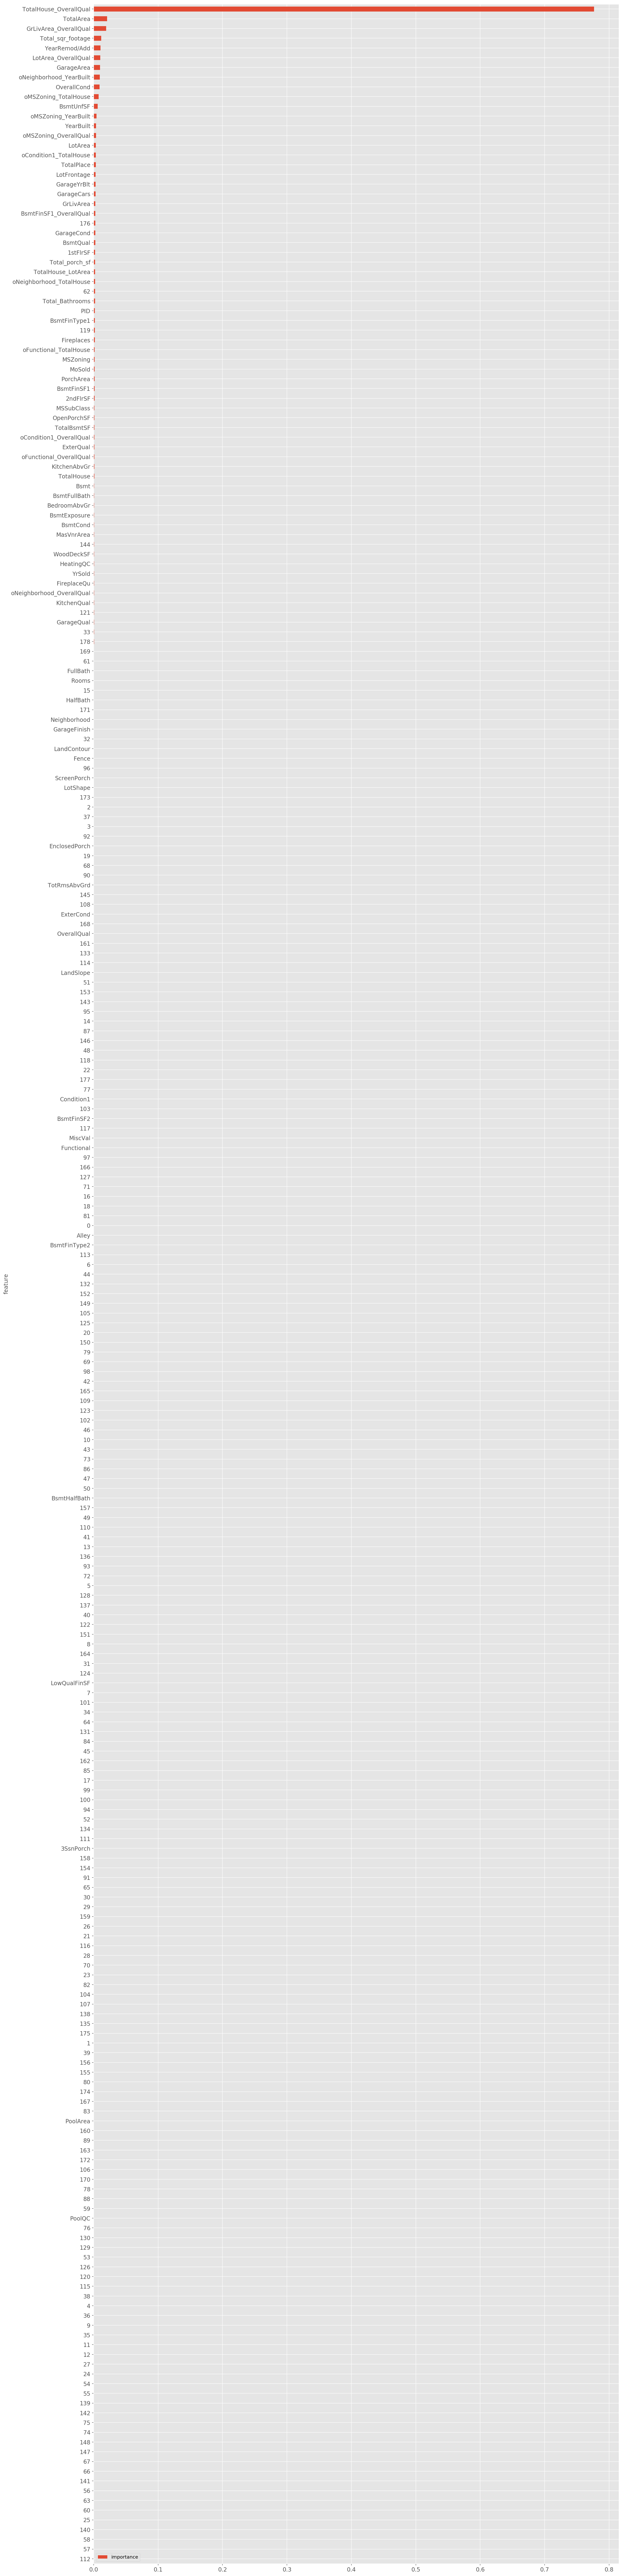

In [48]:
model = model.fit(X_train, y)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = model.named_steps['rf'].feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20, 100), fontsize=12);

### Using PCA


In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=255)

X_train_pca =pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((2048, 255), (879, 255))

### Modeling


We are going to try many models then we will choose the some of them.

In [51]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold


from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression, ElasticNet ,Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from math import sqrt



def get_models():

    #base learners
    rfr = RandomForestRegressor()
    etr = ExtraTreesRegressor()
    lin_r = LinearRegression()
    elastic = ElasticNet()
    lasso = Lasso()
    ridge = Ridge()
    ker_ridge = KernelRidge()
    svr = SVR()
    
    boost = AdaBoostRegressor()
    bagg = BaggingRegressor()
    gradi = GradientBoostingRegressor()
    
    xgb = XGBRegressor()
    
    lgb = LGBMRegressor()
    


    models = {
              'Random Forest': rfr,
              'Extra Trees': etr,
              'Linear Regression': lin_r,
              'ElasticNet': elastic,
              'Lasso': lasso,
               'Ridge':ridge,
                'Ker_ridge':ker_ridge,
                'SVR':svr,
              
              
              'AdaBoost': boost,
              'Bagging': bagg,
              'GradientBoost':gradi,
              'XGB':xgb,
              'LGB':lgb
        
              }

    return models

/Users/greener/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [52]:
#RMSE function
def rmse_cv(model, X=X_train_pca, y=y ):
    k_fold = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_scores = np.sqrt(-cross_val_score(model, X , y , cv=k_fold, scoring='neg_mean_squared_error'))
    return(cv_scores)

In [53]:
# Models comparison
models = get_models()

results = []
for name, model in zip(models.keys(),models.values()):

    rmse_scores = rmse_cv(model)
    results.append(rmse_scores)
    print( f"{name}. RMSE CV score: {np.mean(rmse_scores)} , Std: {rmse_scores.std()}.")

Random Forest. RMSE CV score: 0.16679593055375677 , Std: 0.01714551825070952.
Extra Trees. RMSE CV score: 0.15401194417890032 , Std: 0.008994309066536968.
Linear Regression. RMSE CV score: 6440727943.728777 , Std: 12523981291.10117.
ElasticNet. RMSE CV score: 0.272415686434451 , Std: 0.014530463842773657.
Lasso. RMSE CV score: 0.3492713482957141 , Std: 0.018366928750897446.
Ridge. RMSE CV score: 0.12117908450245514 , Std: 0.013138941575562217.
Ker_ridge. RMSE CV score: 13.739191943433202 , Std: 0.34933553316448623.
SVR. RMSE CV score: 0.12085091930275216 , Std: 0.01567125125211131.
AdaBoost. RMSE CV score: 0.18174743442684946 , Std: 0.007846048661495896.
Bagging. RMSE CV score: 0.1669593409695082 , Std: 0.00948186596584613.
GradientBoost. RMSE CV score: 0.14255225489722254 , Std: 0.009197603652406721.
XGB. RMSE CV score: 0.1447784287054409 , Std: 0.010661552743853256.
LGB. RMSE CV score: 0.1460310431211447 , Std: 0.01066785970058746.


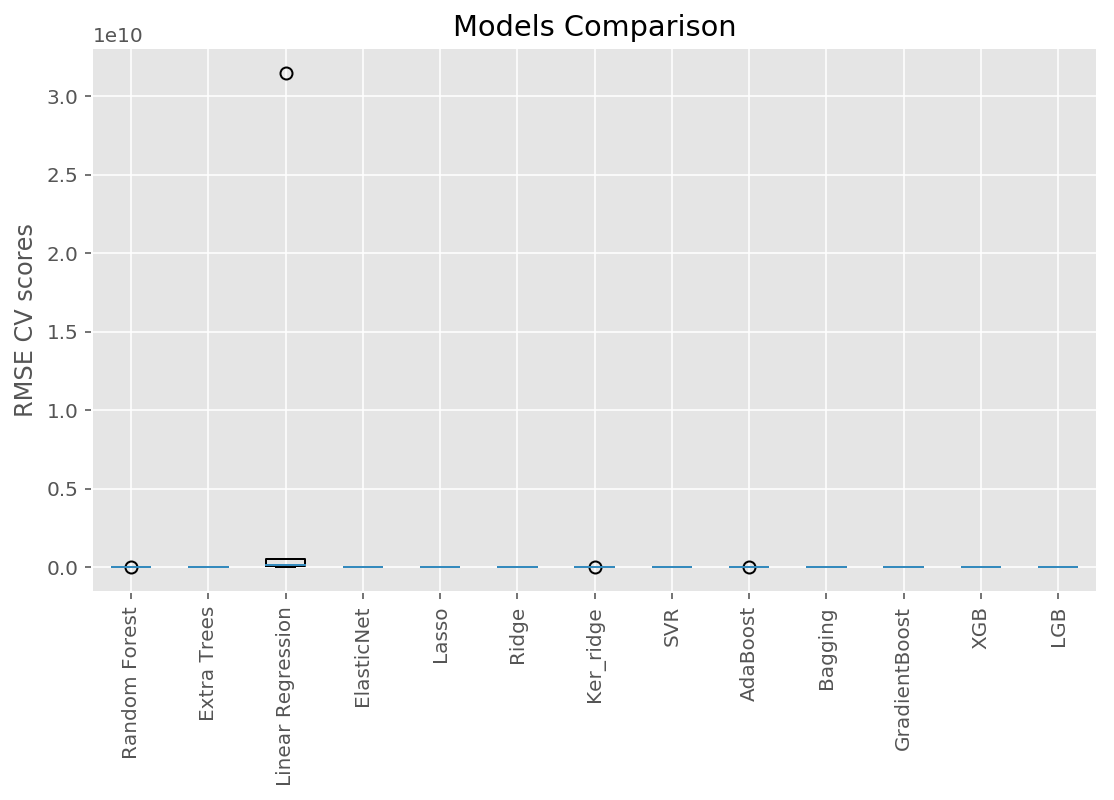

In [54]:
# visualise models comparison
fig = plt.figure( figsize=(9,5))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels([name for name in models.keys()], rotation=90)
ax.set(title='Models Comparison', ylabel='RMSE CV scores');

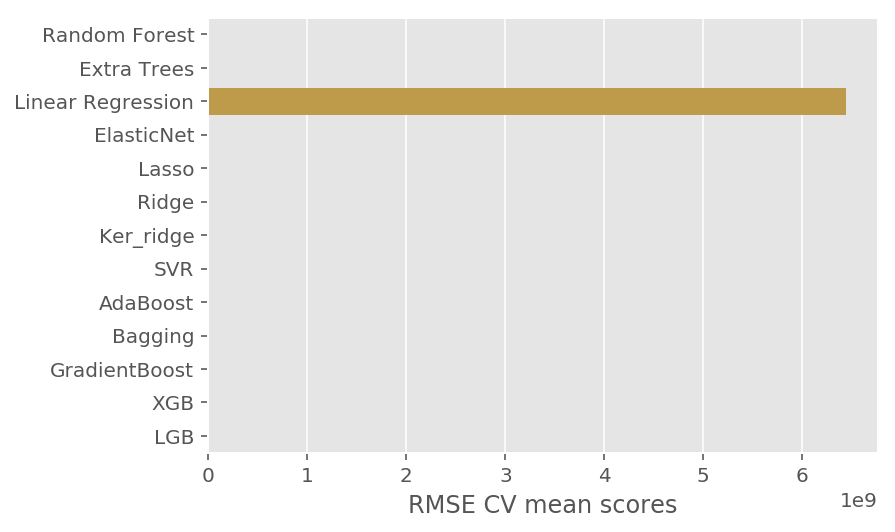

In [55]:
sns.barplot(y=[name for name in models.keys()],x=[np.mean(r) for r in results] );
plt.xlabel('RMSE CV mean scores');

### Hyperparameters Tuning

In [56]:
dict_grid = {'Random Forest': { },
             
             'Extra Trees': { 'n_estimators': [100, 500]},
             
             'Linear Regression': {'n_jobs':[-1]},
             
             'ElasticNet': {'alpha': [ 1.0 , 0.0001 , 0.0005 ,10], 'l1_ratio': [0.1 , 0.5 , 0.8]} ,
             
             'Lasso': {'alpha': [1.0 , 0.0001 ,0.0005]},
             
             'Ridge': {'alpha': [10 , 50 ,80]},
             
             'Ker_ridge': { 'alpha': [1.0 , 0.0001 ,10], 'kernel': ['poly', 'rbf']},
             
             'SVR': {'kernel': ['poly', 'rbf']},
             
             'AdaBoost': {'n_estimators': [50 ,100 , 500]},
             'Bagging': {'n_estimators': [10 ,50 , 500]},
             'GradientBoost': {'n_estimators': [50 ,100 , 500]},
             'XGB': {},
             'LGB': {} }

In [ ]:
# Models comparison
models = get_models()

tunned_models = []
for name, model , param in zip(models.keys(), models.values(), dict_grid.keys() ):
    
    tunned_model = GridSearchCV(model, param_grid = dict_grid[param] ,cv=5 , scoring='neg_mean_squared_error')
    tunned_model.fit(X_train_pca, y)
    print( name)
    print('best score: ',np.sqrt(-tunned_model.best_score_))
    print('best params: ',tunned_model.best_params_)
    print('_____________________________\n'*2)
    


In [57]:
# Selecting models based on GridSearchCV 
# setting models' hyperparameters
rfr = RandomForestRegressor()
etr = ExtraTreesRegressor(n_estimators=100)
elastic = ElasticNet(alpha=0.0005,l1_ratio=0.08)
lasso = Lasso(alpha=0.0005)
ridge = Ridge(alpha=10)
ker_ridge = KernelRidge(alpha=1.0, kernel='poly')
svr = SVR(kernel='rbf')
    
boost = AdaBoostRegressor(n_estimators=50)
bagg = BaggingRegressor(n_estimators=500)
gradi = GradientBoostingRegressor(n_estimators=500)
    
xgb = XGBRegressor()
    
lgb = LGBMRegressor()
    

## Ensemble Methods:

###  Stacking 

In [58]:
from mlxtend.regressor import StackingRegressor

# Selecting the best models based on GridSearchCV as base learners for Stacking
base_learners = [lasso, ridge, svr, ker_ridge, elastic]

# Select the best model based on GridSearchCV as meta model for Stacking
meta_learner = ker_ridge

Stacking_model = StackingRegressor( regressors= base_learners, meta_regressor= meta_learner )


In [59]:
Stacking_model.fit(X_train_pca, y)

StackingRegressor(meta_regressor=KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='poly',
      kernel_params=None),
         refit=True,
         regressors=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_st...False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [60]:
print(np.sqrt( mean_squared_error(y , Stacking_model.predict(X_train_pca))))

0.08606735099587236


In [61]:
# As we used log for our y target know we need to use np.exp (e^x) for the predicted y 
y_pre = np.exp(Stacking_model.predict(X_test_pca))

In [62]:
test_df = pd.DataFrame({'Id':house_test.Id,'SalePrice':y_pre })

In [ ]:
test_df.to_csv('f15.csv', encoding='utf-8' , index=False) 

### Model Averaging

Simple models averaging method 

We will fit the best models with the training data and then average the prediction

In [ ]:
models = [lasso, ridge, svr, ker_ridge, elastic]

# fit all models
[models[i].fit(X_train_pca, y) for i in range(len(models))]

#stack the predictions for all models
models_y_pred = np.column_stack([models[i].predict(X_test_pca) for i in range(len(models))])

# average the predictions
predictions_mean = np.mean(models_y_pred, axis=1)
    

In [ ]:
# As we used log for our y target know we need to use np.exp (e^x) for the predicted y 
y_pre = np.exp(predictions_mean)

test_df = pd.DataFrame({'Id':house_test.Id,'SalePrice':y_pre })

test_df.to_csv('f16.csv', encoding='utf-8' , index=False) 

### Average Weight ensemble


In [ ]:
models = [lasso, ridge, svr, ker_ridge, elastic]
# assign weights each model based on their score
weights = [0.02, 0.3, 0.25, 0.4, 0.03]

# fit all models
[models[i].fit(X_train_pca, y) for i in range(len(models))]

#stack the predictions for all models
models_y_pred = np.column_stack([models[i].predict(X_test_pca)*weights[i] for i in range(len(models))])

# average the predictions
predictions_mean = np.mean(models_y_pred, axis=1)
    

In [ ]:
# As we used log for our y target know we need to use np.exp (e^x) for the predicted y 
y_pre = np.exp(predictions_mean)

test_df = pd.DataFrame({'Id':house_test.Id,'SalePrice':y_pre })

test_df.to_csv('f17.csv', encoding='utf-8' , index=False) 

### Things we tried but did not work: 

- with StackingRegressor:

    * reduce the features 
    * adding lasso and ridge 
    * Standardize features 

    * adding one hot encoding to the categorical features with feature selection to be 36 features selected by GradientBoostingRegressor model gives a good impact on results


- Imputing the missing values using Knn
- just using GradientBoostingRegressor model without stacking gives a good impact on results
    * just using GradientBoostingRegressor model with tunning without stacking gives a good impact on results 
    
- using a function to average results (staking )  

- StandardScaler gives bad results and we think that was because of outliers as the scikit-learn (http://scikit-learn.org/0.18/auto_examples/preprocessing/plot_robust_scaling.html) themselves clearly warn for such a case: 

        " However, when data contains outliers, StandardScaler can often be mislead. In such cases, it is better to use a scaler that is robust against outliers."
- RobustScaler gives good results 




##### References:

[1] How to deal with Skewed Dataset in Machine Learning? : https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc

[2] https://www.kaggle.com/kripakaran/house-prices

[3] https://www.kaggle.com/tomide/stacked-regressions-top-4-on-leaderboard

